### __3) Visual search with k-NN__ 

The idea here is to implement a little search engine based on the high-level image
representation and k-nearest neighbors

- Fit and tune a k-NN classifier
- Pick an image from the test set and plot its 10 nearest neighbors from the train set

Hint: take a look at the kneighbors() method from Scikit-learn k-NN estimators.

#### Fit and tune a k-NN classifier

In [1]:
import matplotlib.image as mpimg
import glob
import numpy   as np
import pandas  as pd


import os
import tensorflow as tf 
from sklearn.preprocessing   import StandardScaler
from sklearn.neighbors       import NearestNeighbors
from sklearn.pipeline        import Pipeline
from sklearn.neighbors       import KNeighborsClassifier
from PIL                     import Image
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pickle






In [2]:
data_dir = 'C:/Users/tgdreju4/OneDrive - Swisscom/EPFL/Notebooks/04ML/swissroads/'
my_dir = data_dir + 'test/'

Code snipplet used in this notebook:
- https://heartbeat.fritz.ai/understand-the-fundamentals-of-the-k-nearest-neighbors-knn-algorithm-533dc0c2f45a
        

Load the data from the npz file

In [3]:
#dir =r'C:/Users/tgdreju4/OneDrive - Swisscom/EPFL/Notebooks/04ML/swissroads'

with np.load(data_dir + 'train.npz', allow_pickle=False) as npz_file:
    X_tr   = npz_file['features']
    y_tr   = npz_file['labels']
    train_data = dict(npz_file.items())

    
with np.load(data_dir + 'test.npz', allow_pickle=False) as npz_file:
    X_te = npz_file['features']
    y_te   = npz_file['labels']    
    test_data = dict(npz_file.items())
    
with np.load(data_dir + 'valid.npz', allow_pickle=False) as npz_file:
    X_va = npz_file['features']
    y_va   = npz_file['labels']    
    valid_data = dict(npz_file.items())    

# Create X/y arrays
X_tr = train_data['features']
X_te = test_data['features']
X_va = valid_data['features']
y_tr = train_data['labels']
y_te = test_data['labels']
y_va = valid_data['labels']
z_tr = train_data['files']
z_te = test_data['files']
z_va = valid_data['files']



#### Fit and tune a knn classifier using GridSearchCV

In [4]:
# define models and parameters
model       = KNeighborsClassifier()
n_neighbors = np.arange(1, 40, 2)
weights     = ['uniform', 'distance']
metric      = ['euclidean', 'manhattan', 'minkowski']


# define grid search
grid      = dict(n_neighbors=n_neighbors,
           weights=weights,
           metric=metric)
    
#cv         = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)


grid_search = GridSearchCV(
         estimator=model, 
         param_grid=grid, 
         n_jobs=-1, 
         #cv=cv, 
         scoring='accuracy',error_score=0, verbose=1)

grid_result = grid_search.fit(X_tr, y_tr)

# summarize results
print("Best score with grid search is : %f using knn = %s" % (grid_result.best_score_, grid_result.best_params_))


C:\Users\tgdreju4\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.1s


Best score with grid search is : 0.828571 using knn = {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.0s finished
C:\Users\tgdreju4\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Fit and tune a knn classifier searching for the best knn

In [5]:
from sklearn import metrics

# Generate a set of k values between 1 and 40
k_values = np.arange(1, 40, 2)



gs_results  = []
# Create k-NN classifier
knn = KNeighborsClassifier(
    #n_neighbors=4, # Set k to 5
    algorithm='brute' # use brute strategy (faster)
)

# Create the pipeline and fit it to training data
knn_pipe = Pipeline([
    ('scaler', StandardScaler()), # With standardization
    ('knn', knn)
])


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit( X_tr,y_tr ) 
    #knn_pipe.fit( np.concatenate((X_tr, X_va), axis=0),  np.concatenate((y_tr, y_va), axis=0) )

    
    # Save model and its performance on train/test sets
    gs_results.append({
        'k': k,
        'train_accuracy': knn_pipe.score(X_tr, y_tr),
        'valid_accuracy': knn_pipe.score(X_va, y_va),
        'test_accuracy':  knn_pipe.score(X_te, y_te)        
    })
 
# Capture results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by=['valid_accuracy', 'k'], ascending=False).head(10) # sort by best valid result 


,k,test_accuracy,train_accuracy,valid_accuracy
1,3,0.90,0.925000,0.899281
2,5,0.92,0.907143,0.884892
0,1,0.90,1.000000,0.884892
3,7,0.92,0.889286,0.870504
6,13,0.90,0.850000,0.856115
4,9,0.90,0.864286,0.848921
5,11,0.90,0.860714,0.841727
11,23,0.88,0.817857,0.834532
10,21,0.88,0.821429,0.834532
14,29,0.88,0.800000,0.820144


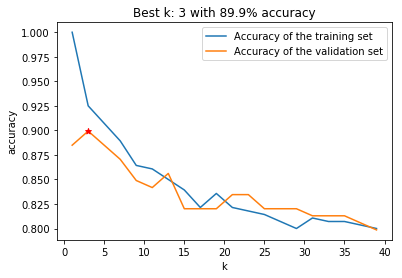

In [6]:
grouped = gs_results.groupby('k')

# Compute train/test mean
mean_tr = grouped.train_accuracy.mean()
mean_va = grouped.valid_accuracy.mean()


# Plot mean scores
plt.plot(k_values, mean_tr, label='Accuracy of the training set')
plt.plot(k_values, mean_va, label='Accuracy of the validation set')

# Add marker for best score
best_k = mean_va.idxmax()
plt.scatter(best_k, mean_va.max(), marker='*', c='red', zorder=10)

# Quantify variance with ±std curves
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*mean_va[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()


__Result:__

> Find the best accuracy value which can be reached by the number of neighbors in this chart above.




#### Pick image from test set and plot 10 nn from the train set

In [7]:
# Pick image from test set and plot 10 nn from the train set
testimage = 19

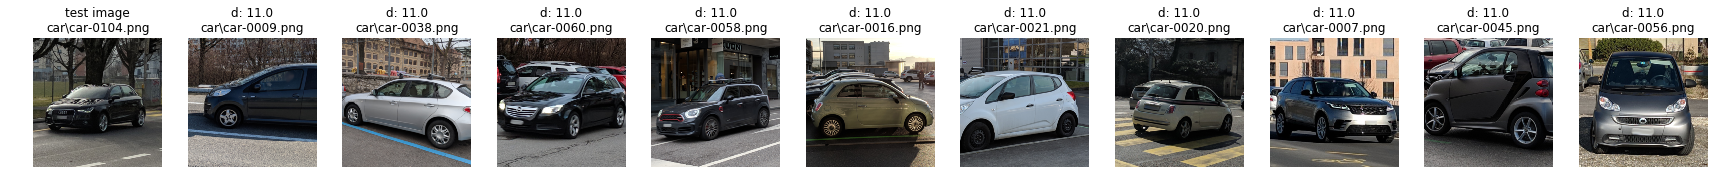

In [8]:
my_test_dir    = data_dir + 'test'
my_train_dir   = data_dir + 'train'
my_valid_dir   = data_dir + 'valid'
fullpath_test  = my_test_dir + "/" + z_te[testimage]
# define subplot   
fig,axes = plt.subplots(1,11, figsize=(30, 20))


# get testimage and plot it in first position of subplot
img = Image.open(fullpath_test)  
axes[0].set_title('test image\n{}'.format(z_te[testimage]))
axes[0].axis('off')
axes[0].imshow(img)



# fit train data
knn10 = KNeighborsClassifier(n_neighbors=10, algorithm='brute')
knn10.fit(X_tr, y_tr)

# get the 10 neighbors
distances, indices = knn10.kneighbors([X_te[testimage]],return_distance=True)


# plot 10 neighbor images to testimage
for j in range(1,11):
    fullpath_train = my_train_dir  + "/" + z_tr[indices[0][j-1]]    
    img=mpimg.imread(fullpath_train)
    axes[j].imshow(img)
    axes[j].set_title('d: {}\n{}'.format(distances[0][j-1].round(0), z_tr[indices[0][j-1]] )) 
    axes[j].axis('off')


    


#### Collect results

In [9]:
# Create dataframe and collect all results

df = pd.DataFrame({
          'model':        'knn',
          'test accuracy': knn_pipe.score(X_te, y_te) },index=[0] )

# store results in csv
df.to_csv(data_dir + 'data.csv')
# read all results from csv and print 
df = pd.read_csv(data_dir + 'data.csv', index_col=0)
df

,model,test accuracy
0,knn,0.84
